In [34]:
import csv
import json
import pickle
import numpy as np
from scipy.stats import pearsonr, wilcoxon, ks_2samp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import maxabs_scale
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [2]:
# Preprocess data
def preprocess(tweets):
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_USER = re.compile("@.+?\s")
    tweets = [REPLACE_NO_SPACE.sub("", line.lower()) for line in tweets]
    tweets = [REPLACE_USER.sub("@_ ", line.lower()) for line in tweets]
    return tweets

In [3]:
# Get features for a tweet using count vectorizer
def get_feats(tweets):
    feats = cv.transform(tweets)
    feats = maxabs_scale(feats)
    return feats

In [4]:
def getTweetsDiff(tweets1, tweets2):
    diffTweets = defaultdict(list)
    
    for key in tweets1:
        for tweet in tweets1[key]:
            if tweet not in tweets2[key]:
                diffTweets[key].append(tweet)
        
    return diffTweets

In [5]:
# Load in model trained on large set of tweets
cv = pickle.load(open("vectorizer.p", "rb"))

In [6]:
final_model = pickle.load(open("model.p", "rb"))

In [7]:
# Load movie data
movie_tweets = json.load(open("movie_data/movie_tweets_week.json", "r"))
movie_tweets_no_bots = json.load(open("movie_data/movie_tweets_week_no_bots.json", "r"))

In [48]:
movie_scores = {}
movie_scores_bots = []
movie_scores_no_bots = []

In [49]:
# Get average sentiment for each movie with bots filtered out
for movie, data in sorted(movie_tweets_no_bots.items(), key=lambda x:x[0]):
    tweets = [tweet["text"] for tweet in data]
    feats = get_feats(tweets)
    preds = final_model.predict(feats)
    
    # Weight by likes
    likes = [tweet["favorite_count"] for tweet in data]
    preds = np.multiply(preds, likes)
    preds = np.divide(preds, sum(likes))
    
    movie_scores_no_bots.append(np.sum(preds, axis=0))

In [50]:
# Get average sentiment for each movie with bots included
for movie, data in sorted(movie_tweets.items(), key=lambda x:x[0]):
    tweets = [tweet["text"] for tweet in data]
    feats = get_feats(tweets)
    preds = final_model.predict(feats)
    
    # Weight by likes
    likes = [tweet["favorite_count"] for tweet in data]
    preds = np.multiply(preds, likes)
    preds = np.divide(preds, sum(likes))
    
    movie_scores[movie] = [np.sum(preds, axis=0), None, None]
    movie_scores_bots.append(np.sum(preds, axis=0))

In [51]:
# Compare bots with no bots
tstat, tpval = wilcoxon(movie_scores_no_bots, movie_scores_bots)
print("stat: {}, p-value: {}".format(tstat, tpval))
print("Mean with bots: ", np.mean(movie_scores_bots))
print("Mean with no bots: ", np.mean(movie_scores_no_bots))

stat: 5.0, p-value: 0.00018876804289503734
Mean with bots:  0.8120888297152143
Mean with no bots:  0.8100700277248732


In [12]:
# Load in critic and audience scores
with open("movie_data/movie_info.csv", "r") as review_file:
    review_reader = csv.reader(review_file)
    next(review_reader)
    for row in review_reader:
        movie_scores[row[0]][1] = int(row[5])/100
        movie_scores[row[0]][2] = int(row[4])/100

Correlation =  -0.3225134446134798
p-value     =  0.1654893281231586


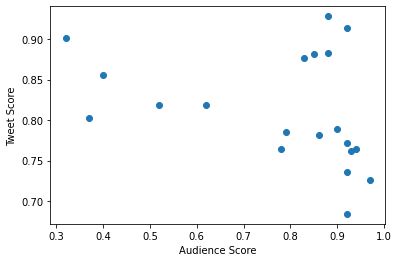

In [13]:
# Get correlation with audience score
x = [score[1] for score in movie_scores.values()]
y = [score[0] for score in movie_scores.values()]
corr, p = pearsonr(x, y)
print("Correlation = ", corr)
print("p-value     = ", p)
plt.scatter(x, y)
plt.xlabel("Audience Score")
plt.ylabel("Tweet Score")
plt.show()

Correlation =  -0.2720994350315084
p-value     =  0.2458150223037611


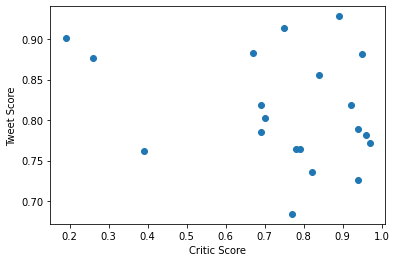

In [14]:
# Get correlation with critic score
x = [score[2] for score in movie_scores.values()]
y = [score[0] for score in movie_scores.values()]
corr, p = pearsonr(x, y)
print("Correlation = ", corr)
print("p-value     = ", p)
plt.scatter(x, y)
plt.xlabel("Critic Score")
plt.ylabel("Tweet Score")
plt.show()

In [191]:
# gets tweets from bots only
movie_tweets_only_bots = getTweetsDiff(movie_tweets, movie_tweets_no_bots)
for movie in movie_scores_only_bots:
    print(len(movie_scores_only_bots[movie]), len(movie_tweets[movie])-len(movie_tweets_no_bots[movie]))

18 18
3 3
13 13
13 13
26 26
17 17
12 12
12 12
24 24
17 17
4 4
15 15
10 10
4 4
14 14
19 19
28 28
11 11
8 8
8 8


In [184]:
tweet_scores_no_bots = []
tweet_scores_bots_only = []

In [185]:
# Get sentiment per tweet for each movie with bots filtered out
for movie, data in sorted(movie_tweets_no_bots.items(), key=lambda x:x[0]):
    tweets = [tweet["text"] for tweet in data]
    feats = get_feats(tweets)
    preds = final_model.predict(feats)
    
    # Weight by likes
    likes = np.array([tweet["retweet_count"] for tweet in data])+1
    preds = np.multiply(preds, likes)
    preds = np.divide(preds, sum(likes))
    
    tweet_scores_no_bots.append(preds)

In [186]:
# Get sentiment per tweet for each movie with bots only
for movie, data in sorted(movie_tweets_only_bots.items(), key=lambda x:x[0]):
    tweets = [tweet["text"] for tweet in data]
    feats = get_feats(tweets)
    preds = final_model.predict(feats)

    # Weight by likes
    likes = np.array([tweet["retweet_count"] for tweet in data])+1
    preds = np.multiply(preds, likes)
    preds = np.divide(preds, sum(likes))
    tweet_scores_bots_only.append(preds)

In [187]:
for noBots, botsOnly in zip(tweet_scores_no_bots, tweet_scores_bots_only):
    ksstat, kspval = ks_2samp(noBots, botsOnly)

    #print("KS-stat: {}, p-value: {}".format(ksstat, kspval))
    print(np.average(botsOnly)- np.average(noBots))

0.06540886227254249
0.05806418984682092
0.043968343752086365
0.06828902166017696
0.08959199683067967
0.0427230013244938
0.054326011878042056
0.33201187249967734
0.0356590155055055
0.06435065875948291
0.06899158205328473
0.12389265386574536
0.05989751407651391
0.11438141469670635
0.03856728210246174
0.07031402256792428
0.24788486823300748
0.0332432977490592
0.24881264777837003
0.05763027325649269
